# **Ouroboros EEG-fMRI NF: Predicting EEG activity, fMRI activity and NF scores**

#### Version: 28th October 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through six Notebooks:

*01: Data Analysis*

***02: Classification* (all classification models except neural networks)**

*03: Neural Networks*

*04: Regression on fMRI Data*

*05: Regression on EEG Data*

*06: Results*

==============================================================================================

### Notebook 02

# **Classification**

## **1. Introduction to Classification**

### 1.1 Objective

The objective of this project is to **explore several ways to apply machine learning models to a given EEG-fMRI NF dataset, and to evaluate which ones result in interesting predictions**. In this Notebook, we will evaluate whether EEG data, fMRI data, or a combination of both, can be used to predict the **brain state** of the subject, i.e. when he/she is at rest versus when he/she is performing the NF task. 

In the previous Notebook, we have computed several **EEG bandpowers** covering the major frequency bands: delta (1-4 Hz), theta (4-8 Hz), alpha (8-12 Hz), beta (12-30 Hz) and high beta (30-50 Hz). For all subjects, these bandpowers were extracted for the C1 channel, and for the first subject, the bandpowers were also computed for all the other channels. Also, we have preprocessed the images containing the **fMRI BOLD signal**, by eliminating the signal of the voxels located roughly outside the brain, and rescaling the voxel size by a factor 2 or 3, while also keeping the images with the original voxel size. Finally, we have performed two PCA, with 200 and 10 components respectively, on the fMRI data. We will now use all these predictors as features for our classification models. 

### 1.2 Models

We will use a variety of classification models: **k-NN**, **decision tree**, **random forest**, **SVM**, **logistic regression**. For all subjects, we will fine-tune the hyperparameters of these models using a grid search with cross-validation approach, and store the test score as well as the value of the best hyperparameter found. The baseline will be a model that always predicts the most frequent value from the train set. 

### 1.3 Data import

Here we import the **EEG and fMRI data**. For the latter, we store the data in dictionaries. We also define the **target variable**, which will be the same for all subjects since the experimental design was identical for all the eegfmriNF runs. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the raw data path. 
data_path = '../ouroboros_eeg-fmri_nf_raw_data/'

# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_eeg-fmri_nf_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(10):
    if subject_index < 9:
        subjects.append('sub-xp10' + str(subject_index + 1))
    else:
        subjects.append('sub-xp1' + str(subject_index + 1))

print(subjects)

['sub-xp101', 'sub-xp102', 'sub-xp103', 'sub-xp104', 'sub-xp105', 'sub-xp106', 'sub-xp107', 'sub-xp108', 'sub-xp109', 'sub-xp110']


In [4]:
# Load the EEG predictors. 
with open(preprocessed_data_path + 'predictors_EEG_200_samples.p', 'rb') as file:
    predictors_EEG_200_samples = pickle.load(file)
with open(preprocessed_data_path + 'predictors_EEG_1600_samples.p', 'rb') as file:
    predictors_EEG_1600_samples = pickle.load(file)
with open(preprocessed_data_path + 'predictors_EEG_single_subject_all_channels_200_samples.p', 'rb') as file:
    predictors_EEG_single_subject_all_channels_200_samples = pickle.load(file)
with open(preprocessed_data_path + 'predictors_EEG_single_subject_all_channels_1600_samples.p', 'rb') as file:
    predictors_EEG_single_subject_all_channels_1600_samples = pickle.load(file)
    
# Load the fMRI PCA predictors. 
with open(preprocessed_data_path + 'predictors_fMRI_PCA_200_components.p', 'rb') as file:
    predictors_fMRI_PCA_200_components = pickle.load(file)
with open(preprocessed_data_path + 'predictors_fMRI_PCA_10_components.p', 'rb') as file:
    predictors_fMRI_PCA_10_components = pickle.load(file)

In [5]:
# Load the fMRI data, and store the data in dictionaries. 
predictors_fMRI = dict()
predictors_fMRI_r2 = dict()
predictors_fMRI_r3 = dict()

# Iterate through all subjects. 
counter = 1
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject ' + str(counter) + ' / ' + str(len(subjects)))
    
    # Load fMRI data with the original voxel size. 
    with np.load(preprocessed_data_path + 'predictors_fMRI.npz', allow_pickle = False) as npz_file:
        predictors_fMRI[subject_index] = npz_file['sub_' + str(counter)]
    
    # Load fMRI data with the voxel size rescaling by a factor 2. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r2.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r2[subject_index] = npz_file['sub_' + str(counter)]
        
    # Load fMRI data with the voxel size rescaling by a factor 3. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r3.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r3[subject_index] = npz_file['sub_' + str(counter)]
        
    # Increment. 
    counter += 1

Starting subject 1 / 10
Starting subject 2 / 10
Starting subject 3 / 10
Starting subject 4 / 10
Starting subject 5 / 10
Starting subject 6 / 10
Starting subject 7 / 10
Starting subject 8 / 10
Starting subject 9 / 10
Starting subject 10 / 10


In [6]:
# Determine the proportion of the test set for the classification models. 
test_set_proportion = 0.2

In [7]:
# Retrieve and display the events file for the eegfmriNF run. 
events = pd.read_csv(data_path + 'task-eegfmriNF_events.tsv', sep = '\t')
events

,onset,duration,trial_type,stim_file
0,2,20,Rest,Rest_Xp1.png
1,22,20,Task-NF,Task-NF_Xp1.png
2,42,20,Rest,Rest_Xp1.png
3,62,20,Task-NF,Task-NF_Xp1.png
4,82,20,Rest,Rest_Xp1.png
5,102,20,Task-NF,Task-NF_Xp1.png
6,122,20,Rest,Rest_Xp1.png
7,142,20,Task-NF,Task-NF_Xp1.png
8,162,20,Rest,Rest_Xp1.png
9,182,20,Task-NF,Task-NF_Xp1.png


We are interested in the **brain state** variable, i.e. whether the subject is currently in a **rest block** or in a **task block**. This target variable is easy to reconstruct, since for all subjects, the eegfmriNF run simply consists of an alternance of 10 rest blocks and 10 task blocks, with each block lasting for 20 seconds. The fMRI Repetition Time (TR) is 2 seconds, therefore we have 10 fMRI images per block, and we also computed the EEG bandpowers in order to have 10 samplings per block. The first onset is at 2 seconds and the article indicates that the first fMRI image should be discarded, but we already took that into account in the previous Notebook. 

In [8]:
# Define and display the target variable. 
y = np.repeat(np.tile([0, 1], 10), 10)
print(y)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [9]:
# Display the shape of the target variable. 
y.shape

(200,)

## **2. Classification based on EEG data**

### **2.1 All subjects, C1 channel**

In this section, we try to predict the brain state for **all subjects**, using the **EEG bandpowers computed from the C1 channel**. These bandpowers cover the major frequency bands: delta (1-4 Hz), theta (4-8 Hz), alpha (8-12 Hz), beta (12-30 Hz) and high beta (30-50 Hz). 

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [11]:
# Define a function to run a classification model. 
def run_classification(grid_cv, param_name, predictors_dict, target):
    
    # Create a Pandas DataFrame to store the results. 
    model_results = pd.DataFrame()

    # Iterate through all subjects. 
    for subject_index in subjects:

        # Display current step. 
        print('Starting subject ' + subject_index)

        # Retrieve the predictors. 
        X = predictors_dict[subject_index]
        y = target

        # Divide the data into a train set and a test set. 
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

        # Create a baseline containing only the most frequent value in the train set. 
        most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
        classification_baseline = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]

        # Fit the model. 
        grid_cv.fit(X_tr, y_tr)

        # Compute the test score. 
        test_score = grid_cv.score(X_te, y_te)

        # Store the results in the DataFrame. 
        model_results.loc[subject_index, param_name] = grid_cv.best_params_[param_name]
        model_results.loc[subject_index, 'test score'] = test_score
        model_results.loc[subject_index, 'baseline'] = classification_baseline
        
    return model_results

#### **2.1.1 K-Nearest Neighbors (k-NN)**

In the following cells, we **fine-tune, fit and compute predictions from a k-NN model**. 

In [12]:
# Disable warnings. 
import warnings
warnings.filterwarnings('ignore')

In [13]:
from sklearn.neighbors import KNeighborsClassifier

In [14]:
# Define the set of values to explore, where k is the number of neighbors. 
k_values = np.arange(1, 50, 1)
k_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [15]:
# Create pipeline. 
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Create cross-validation object. 
grid_knn = {
    'knn__n_neighbors': k_values
}
grid_cv_knn = GridSearchCV(pipe_knn, grid_knn, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [16]:
# Run the model. 
knn_results = run_classification(grid_cv_knn, 'knn__n_neighbors', predictors_EEG_200_samples, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [17]:
# Display the results. 
knn_results

,knn__n_neighbors,test score,baseline
sub-xp101,30.0,0.550,0.475
sub-xp102,22.0,0.675,0.400
sub-xp103,5.0,0.725,0.425
sub-xp104,11.0,0.700,0.450
sub-xp105,6.0,0.750,0.475
sub-xp106,1.0,0.550,0.475
sub-xp107,43.0,0.550,0.450
sub-xp108,25.0,0.650,0.475
sub-xp109,35.0,0.475,0.425
sub-xp110,34.0,0.400,0.375


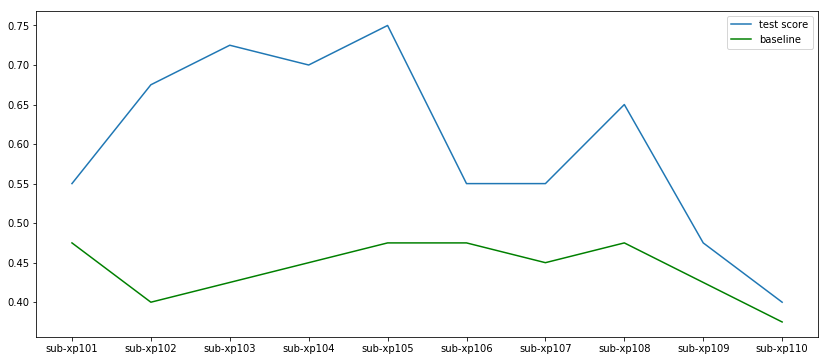

In [18]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(knn_results[['test score']], label = 'test score')
plt.plot(knn_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the k-NN model using the EEG bandpowers as predictors performs better than the baseline for our group of subjects. 

#### **2.1.2 Decision tree**

In the following cells, we **fine-tune, fit and compute predictions from a decision tree model**. 

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
# Define the set of values to explore, where d is the depth of the tree. 
d_values = np.arange(1, 50, 1)
d_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [21]:
# Create pipeline. 
pipe_dt = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeClassifier(criterion = 'gini'))
])

# Create cross-validation object. 
grid_dt = {
    'dt__max_depth': d_values
}
grid_cv_dt = GridSearchCV(pipe_dt, grid_dt, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [22]:
# Run the model. 
dt_results = run_classification(grid_cv_dt, 'dt__max_depth', predictors_EEG_200_samples, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [23]:
# Display the results. 
dt_results

,dt__max_depth,test score,baseline
sub-xp101,2.0,0.525,0.450
sub-xp102,1.0,0.650,0.425
sub-xp103,17.0,0.575,0.375
sub-xp104,1.0,0.775,0.400
sub-xp105,17.0,0.575,0.425
sub-xp106,4.0,0.475,0.450
sub-xp107,4.0,0.700,0.500
sub-xp108,1.0,0.575,0.450
sub-xp109,18.0,0.450,0.475
sub-xp110,41.0,0.500,0.450


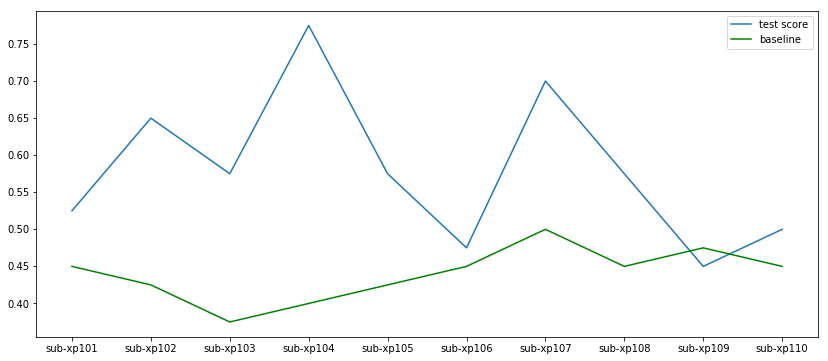

In [24]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(dt_results[['test score']], label = 'test score')
plt.plot(dt_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the decision tree model using the EEG bandpowers as predictors performs better than the baseline for our group of subjects. 

#### **2.1.3 Random forest**

In the following cells, we **fine-tune, fit and compute predictions from a random forest model**. 

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
# Define the set of values to explore, where n is the number of trees. 
n_values = np.arange(5, 105, 5)
n_values

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])

In [27]:
# Create pipeline. 
pipe_rf = Pipeline([
    ('scaler', None),
    ('rf', RandomForestClassifier(max_depth = None))
])

# Create cross-validation object. 
grid_rf = {
    'rf__n_estimators': n_values
}
grid_cv_rf = GridSearchCV(pipe_rf, grid_rf, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [28]:
# Run the model. 
rf_results = run_classification(grid_cv_rf, 'rf__n_estimators', predictors_EEG_200_samples, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [29]:
# Display the results. 
rf_results

,rf__n_estimators,test score,baseline
sub-xp101,70.0,0.675,0.475
sub-xp102,45.0,0.700,0.450
sub-xp103,25.0,0.550,0.500
sub-xp104,30.0,0.600,0.450
sub-xp105,20.0,0.650,0.450
sub-xp106,90.0,0.725,0.475
sub-xp107,35.0,0.550,0.450
sub-xp108,30.0,0.625,0.350
sub-xp109,10.0,0.475,0.475
sub-xp110,30.0,0.550,0.400


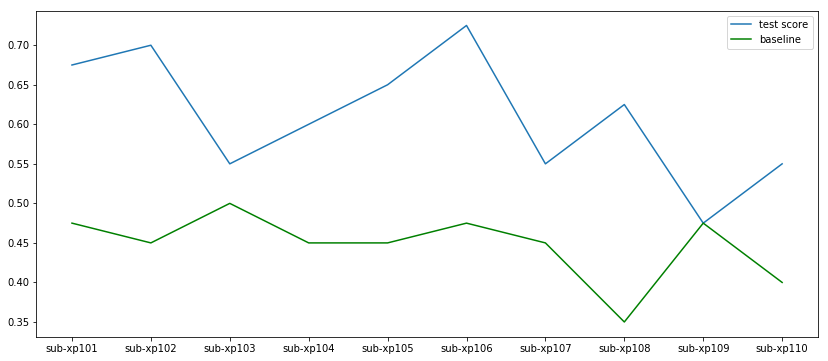

In [30]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(rf_results[['test score']], label = 'test score')
plt.plot(rf_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the random forest model using the EEG bandpowers as predictors performs better than the baseline for our group of subjects. 

#### **2.1.4 Support Vector Machine (SVM)**

In the following cells, we **fine-tune, fit and compute predictions from a SVM model**. 

In [31]:
from sklearn.svm import SVC

In [32]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-3, 3, num = 10)
c_values

array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])

In [33]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [34]:
# Run the model. 
svm_results = run_classification(grid_cv_svm, 'svm__C', predictors_EEG_200_samples, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [35]:
# Display the results. 
svm_results

,svm__C,test score,baseline
sub-xp101,0.464159,0.725,0.450
sub-xp102,0.021544,0.550,0.350
sub-xp103,0.100000,0.725,0.425
sub-xp104,0.464159,0.600,0.425
sub-xp105,0.021544,0.725,0.450
sub-xp106,0.021544,0.700,0.475
sub-xp107,0.021544,0.650,0.500
sub-xp108,0.100000,0.675,0.425
sub-xp109,0.021544,0.375,0.425
sub-xp110,0.021544,0.425,0.425


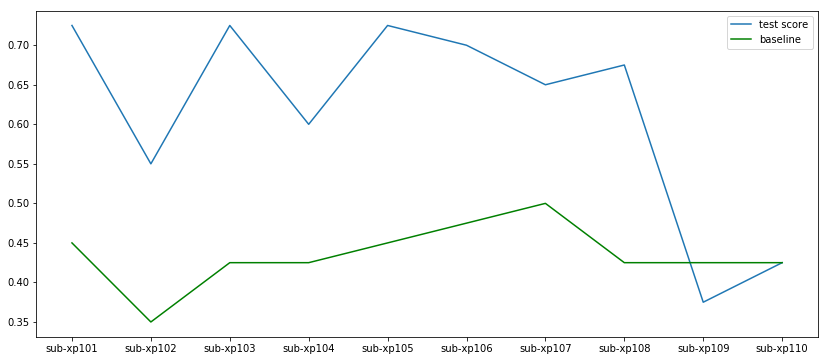

In [36]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(svm_results[['test score']], label = 'test score')
plt.plot(svm_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the SVM model using the EEG bandpowers as predictors performs better than the baseline for our group of subjects. 

#### **2.1.5 Logistic regression**

In the following cells, we **fine-tune, fit and compute predictions from a logistic regression model**. 

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-7, 7, num = 10)
c_values

array([1.00000000e-07, 3.59381366e-06, 1.29154967e-04, 4.64158883e-03,
       1.66810054e-01, 5.99484250e+00, 2.15443469e+02, 7.74263683e+03,
       2.78255940e+05, 1.00000000e+07])

In [39]:
# Create pipeline. 
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Create cross-validation object. 
grid_logreg = {
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['saga'],
    'logreg__C': c_values
}
grid_cv_logreg = GridSearchCV(pipe_logreg, grid_logreg, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [40]:
# Run the model. 
logreg_results = run_classification(grid_cv_logreg, 'logreg__C', predictors_EEG_200_samples, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [41]:
# Display the results. 
logreg_results

,logreg__C,test score,baseline
sub-xp101,0.166810,0.625,0.400
sub-xp102,0.166810,0.525,0.425
sub-xp103,0.004642,0.725,0.475
sub-xp104,0.166810,0.700,0.500
sub-xp105,5.994843,0.750,0.475
sub-xp106,0.166810,0.600,0.450
sub-xp107,5.994843,0.625,0.275
sub-xp108,5.994843,0.750,0.425
sub-xp109,0.004642,0.575,0.450
sub-xp110,0.000004,0.450,0.450


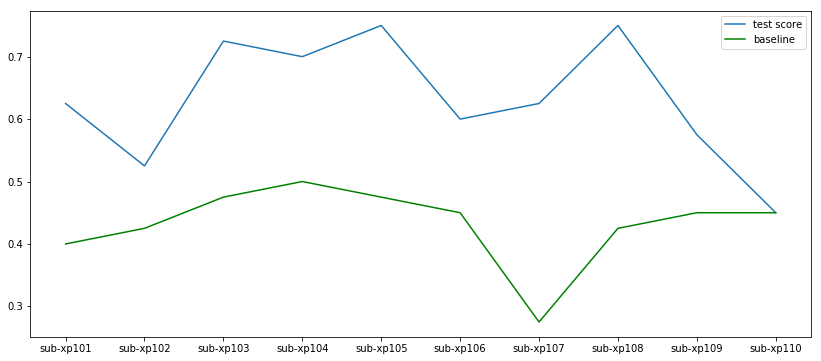

In [42]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(logreg_results[['test score']], label = 'test score')
plt.plot(logreg_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the logistic regression model using the EEG bandpowers as predictors performs better than the baseline for our group of subjects. Now, we will explore further the predictions of our model for one particular subject. 

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
# Define a function to generate a Scikit-learn confusion matrix. 
def scikit_learn_confusion_matrix(y_te, y_pred):
    
    # Compute the confusion matrix. 
    labels = ['rest', 'task']
    matrix = confusion_matrix(
        y_true = y_te,
        y_pred = y_pred, 
        labels = labels
    )

    # Return confusion matrix as a DataFrame. 
    matrix_df = pd.DataFrame(data = matrix, columns = labels, index = labels)
    matrix_df.columns.name = 'Predictions'
    matrix_df.index.name = 'True class'
    return matrix_df

In [45]:
# Define an example subject. 
subject_index = subjects[0]

# Get the C parameter for this subject. 
best_param_logreg = logreg_results.loc[subject_index, 'logreg__C']
best_param_logreg

# Retrieve the predictors for this subject. 
X = predictors_EEG_200_samples[subject_index]

# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

In [46]:
# Create pipeline. 
pipe_logreg_optimal = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class = 'multinomial', solver = 'saga', C = best_param_logreg))
])

# Fit optimal logistic regression. 
pipe_logreg_optimal.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=0.1668100537200059, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False))])

In [47]:
# Compute and display the predictions. 
y_pred_logreg = pipe_logreg_optimal.predict(X_te)
y_pred_logreg

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0])

In [48]:
# Compare the true and predicted target values. 
pred_comparison = pd.DataFrame([y_te, y_pred_logreg], index = ['y_te', 'y_pred_logreg']).T
pred_comparison.T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
y_te,1,0,0,0,0,1,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
y_pred_logreg,0,1,0,0,0,0,1,0,1,1,...,1,0,1,1,1,0,0,0,0,0


In [49]:
# Rename the labels. 
y_te = np.array(['rest', 'task'])[y_te]
y_pred_logreg = np.array(['rest', 'task'])[y_pred_logreg]

# Display a Scikit-learn confusion matrix. 
confusion_matrix_logreg = scikit_learn_confusion_matrix(y_te, y_pred_logreg)
confusion_matrix_logreg

Predictions,rest,task
True class,,
rest,17,7
task,7,9


In the following cells, we explore the results from the logistic regression by analyzing the **probabilities computed for each target value**. In particular, we look at the predicted probability for the true target value. 

In [50]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array(['rest', 'task'], dtype='<U4')

In [51]:
# Compute the probabilities and convert them into a DataFrame with the appropriate column order. 
logreg_probabilities = np.round(pipe_logreg_optimal.predict_proba(X_te), 4)
logreg_probabilities = pd.DataFrame(logreg_probabilities, columns = encoding_order)
logreg_probabilities = logreg_probabilities[['rest', 'task']]

# Add the predicted and true target values. 
logreg_probabilities['predicted target'] = y_pred_logreg
logreg_probabilities['true target'] = y_te

# Compute the predicted probability for the true target value. 
for index in range(0, logreg_probabilities.shape[0]):
    logreg_probabilities.loc[index, 'probability of true target value'] = logreg_probabilities.loc[index, y_te[index]]

# Display the DataFrame. 
logreg_probabilities

,rest,task,predicted target,true target,probability of true target value
0,0.5497,0.4503,rest,task,0.4503
1,0.4474,0.5526,task,rest,0.4474
2,0.5050,0.4950,rest,rest,0.5050
3,0.5288,0.4712,rest,rest,0.5288
4,0.6685,0.3315,rest,rest,0.6685
5,0.5747,0.4253,rest,task,0.4253
6,0.4523,0.5477,task,rest,0.4523
7,0.6130,0.3870,rest,rest,0.6130
8,0.1257,0.8743,task,task,0.8743
9,0.3752,0.6248,task,rest,0.3752


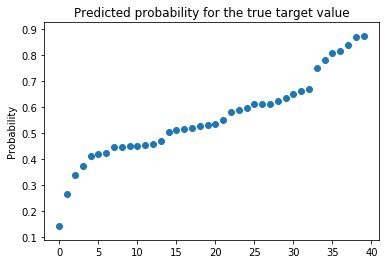

In [52]:
# Display the predicted probability for the true target value, sorted in ascending order. 
plt.scatter(range(0, logreg_probabilities.shape[0]), logreg_probabilities['probability of true target value'].sort_values());
plt.ylabel('Probability')
plt.title('Predicted probability for the true target value');

As we can see, most of the time the probabilities predicted by the logistic regression model have **intermediate values**, neither low nor high. 

In [53]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_EEG_predictors_all_subjects_C1_channel.npz', 
         knn_results = knn_results, 
         dt_results = dt_results, 
         rf_results = rf_results, 
         svm_results = svm_results, 
         logreg_results = logreg_results, 
         logreg_probabilities = logreg_probabilities)

### **2.2 Single subject, all channels**

In this section, we try to predict the brain state for a **single subject**, using the **EEG bandpowers computed from all the channels**. This time, we will simply use a **SVM model**. 

In [54]:
# Store the results with the C1 channel only, for comparison. 
svm_results_C1_channel = svm_results

# Define the features. 
X = predictors_EEG_single_subject_all_channels_200_samples

# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

# Create a baseline containing only the most frequent value in the train set. 
most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
classification_baseline = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]

In [55]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-3, 3, num = 10)
c_values

array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])

In [56]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [57]:
# Fit the model. 
grid_cv_svm.fit(X_tr, y_tr)

# Compute the test score. 
test_score = grid_cv_svm.score(X_te, y_te)

# Create a Pandas Series to store the results. 
svm_results = pd.Series()

# Store the results in the DataFrame. 
svm_results.loc['svm__C'] = grid_cv_svm.best_params_['svm__C']
svm_results.loc['test score'] = test_score
svm_results.loc['baseline'] = classification_baseline

In [58]:
# Display the results. 
svm_results

svm__C        1000.000
test score       0.525
baseline         0.375
dtype: float64

In [59]:
# Compare with the result obtained using only the C1 channel. 
svm_results_C1_channel['test score'][subjects[0]]

0.725

**Result:** Using all channels does not seem to improve the result for this subject, when we compare with the result obtained using only the C1 channel. 

In [60]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_EEG_predictors_single_subject_all_channels.npz', 
         svm_results = svm_results)

## **3. Classification based on fMRI data**

### **3.1 Original voxel size**

In this section, we try to predict the brain state for **all subjects**, using the **fMRI data with the original voxel size**. 

In [61]:
# Define a function to flatten the 3D brain images and remove all NaN values. 
def flatten_preprocessed_fMRI_data(predictors_fMRI):
    
    # Create new dictionaries to store the formatted fMRI data and the non-NaN indexes. 
    predictors_fMRI_flatten = dict()
    non_nan_indexes_fMRI = dict()

    # Iterate through all subjects. 
    for subject_index in subjects:

        # Display current step. 
        print('Starting subject ' + subject_index)

        # Load the data, and retrieve the number and position of non-NaN voxels per scan. 
        image_data = predictors_fMRI[subject_index]
        non_nan_indexes = ~np.isnan(image_data[:, :, :, 0])
        nb_non_nan = np.sum(non_nan_indexes)

        # Retrieve the number of scans, then create a NumPy array with one row per scan and one column per non-NaN voxel. 
        nb_scans = image_data.shape[3]
        formatted_data = np.empty((nb_scans, nb_non_nan))

        # Fill in the array. 
        for scan in range(nb_scans):
            flatten_image = image_data[:, :, :, scan].flatten()
            flatten_image = flatten_image[~np.isnan(flatten_image)]
            formatted_data[scan, :] = flatten_image

        # Fill in the dictionary. 
        predictors_fMRI_flatten[subject_index] = formatted_data
        non_nan_indexes_fMRI[subject_index] = non_nan_indexes
        
    return predictors_fMRI_flatten, non_nan_indexes_fMRI

In [62]:
# Flatten the preprocessed fMRI data with the original voxel size. 
predictors_fMRI_flatten, non_nan_indexes_fMRI = flatten_preprocessed_fMRI_data(predictors_fMRI)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


#### **3.1.1 K-Nearest Neighbors (k-NN)**

In the following cells, we **fine-tune, fit and compute predictions from a k-NN model**. 

In [63]:
# Define the set of values to explore, where k is the number of neighbors. 
k_values = np.arange(1, 3, 1)
k_values

array([1, 2])

In [64]:
# Create pipeline. 
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Create cross-validation object. 
grid_knn = {
    'knn__n_neighbors': k_values
}
grid_cv_knn = GridSearchCV(pipe_knn, grid_knn, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [65]:
# Run the model. 
knn_results = run_classification(grid_cv_knn, 'knn__n_neighbors', predictors_fMRI_flatten, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [66]:
# Display the results. 
knn_results

,knn__n_neighbors,test score,baseline
sub-xp101,2.0,0.800,0.475
sub-xp102,2.0,0.600,0.425
sub-xp103,1.0,0.825,0.500
sub-xp104,1.0,0.825,0.500
sub-xp105,1.0,0.825,0.400
sub-xp106,2.0,0.600,0.450
sub-xp107,1.0,0.750,0.475
sub-xp108,1.0,0.675,0.425
sub-xp109,1.0,0.850,0.475
sub-xp110,1.0,0.725,0.475


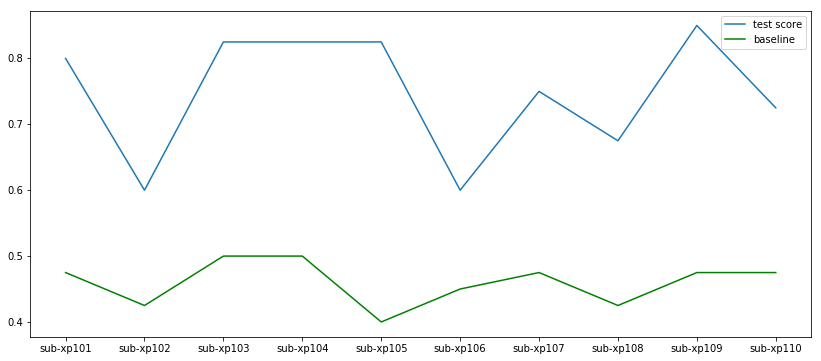

In [67]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(knn_results[['test score']], label = 'test score')
plt.plot(knn_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the k-NN model using the fMRI BOLD values as predictors performs better than the baseline for our group of subjects. 

#### **3.1.2 Decision tree**

In the following cells, we **fine-tune, fit and compute predictions from a decision tree model**. 

In [68]:
# Define the set of values to explore, where d is the depth of the tree. 
d_values = np.arange(1, 5, 1)
d_values

array([1, 2, 3, 4])

In [69]:
# Create pipeline. 
pipe_dt = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeClassifier(criterion = 'gini'))
])

# Create cross-validation object. 
grid_dt = {
    'dt__max_depth': d_values
}
grid_cv_dt = GridSearchCV(pipe_dt, grid_dt, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [70]:
# Run the model. 
dt_results = run_classification(grid_cv_dt, 'dt__max_depth', predictors_fMRI_flatten, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [71]:
# Display the results. 
dt_results

,dt__max_depth,test score,baseline
sub-xp101,1.0,0.675,0.475
sub-xp102,3.0,0.675,0.350
sub-xp103,1.0,0.825,0.450
sub-xp104,1.0,0.575,0.375
sub-xp105,4.0,0.650,0.475
sub-xp106,2.0,0.650,0.475
sub-xp107,2.0,0.825,0.375
sub-xp108,2.0,0.650,0.475
sub-xp109,3.0,0.650,0.450
sub-xp110,1.0,0.675,0.500


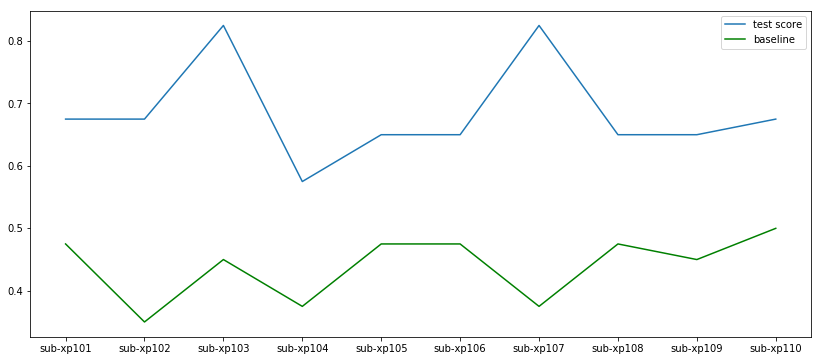

In [72]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(dt_results[['test score']], label = 'test score')
plt.plot(dt_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the decision tree model using the fMRI BOLD values as predictors performs better than the baseline for our group of subjects. 

#### **3.1.3 Random forest**

In the following cells, we **fine-tune, fit and compute predictions from a random forest model**. 

In [73]:
# Define the set of values to explore, where n is the number of trees. 
n_values = np.arange(5, 55, 5)
n_values

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [74]:
# Create pipeline. 
pipe_rf = Pipeline([
    ('scaler', None),
    ('rf', RandomForestClassifier(max_depth = None))
])

# Create cross-validation object. 
grid_rf = {
    'rf__n_estimators': n_values
}
grid_cv_rf = GridSearchCV(pipe_rf, grid_rf, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [75]:
# Run the model. 
rf_results = run_classification(grid_cv_rf, 'rf__n_estimators', predictors_fMRI_flatten, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [76]:
# Display the results. 
rf_results

,rf__n_estimators,test score,baseline
sub-xp101,40.0,0.875,0.375
sub-xp102,50.0,0.625,0.325
sub-xp103,30.0,0.675,0.475
sub-xp104,25.0,0.550,0.500
sub-xp105,30.0,0.875,0.500
sub-xp106,35.0,0.550,0.500
sub-xp107,50.0,0.775,0.475
sub-xp108,45.0,0.775,0.450
sub-xp109,30.0,0.625,0.500
sub-xp110,45.0,0.700,0.450


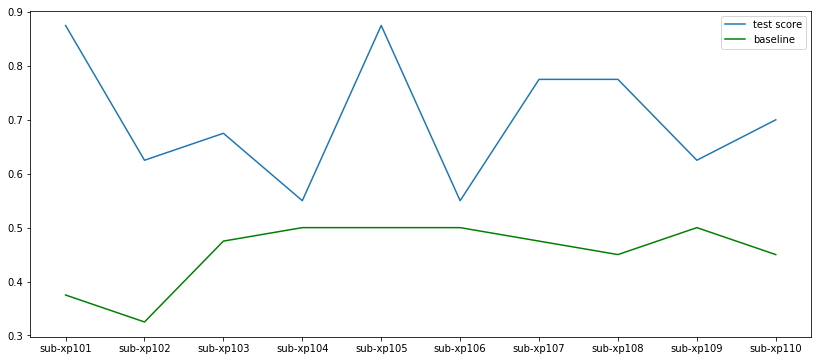

In [77]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(rf_results[['test score']], label = 'test score')
plt.plot(rf_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the random forest model using the fMRI BOLD values as predictors performs better than the baseline for our group of subjects. 

#### **3.1.4 Support Vector Machine (SVM)**

In the following cells, we **fine-tune, fit and compute predictions from a SVM model**. 

In [78]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-2, 2, num = 3)
c_values

array([1.e-02, 1.e+00, 1.e+02])

In [79]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [80]:
# Run the model. 
svm_results = run_classification(grid_cv_svm, 'svm__C', predictors_fMRI_flatten, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [81]:
# Display the results. 
svm_results

,svm__C,test score,baseline
sub-xp101,0.01,0.850,0.500
sub-xp102,0.01,0.800,0.425
sub-xp103,0.01,0.850,0.375
sub-xp104,0.01,0.675,0.400
sub-xp105,0.01,0.825,0.425
sub-xp106,0.01,0.775,0.500
sub-xp107,0.01,0.850,0.450
sub-xp108,0.01,0.875,0.350
sub-xp109,0.01,0.800,0.500
sub-xp110,0.01,0.775,0.425


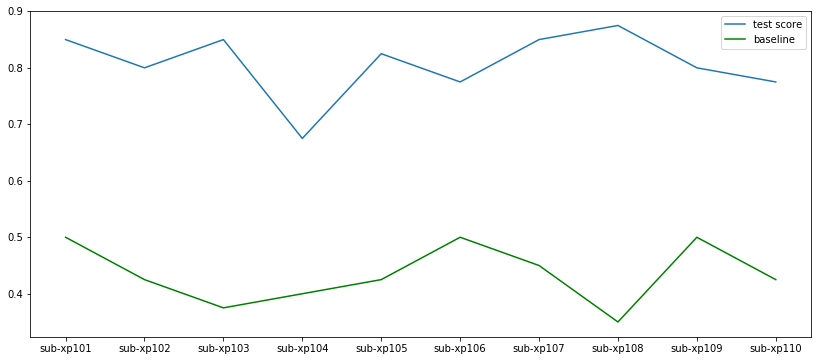

In [82]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(svm_results[['test score']], label = 'test score')
plt.plot(svm_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the SVM model using the fMRI BOLD values as predictors performs better than the baseline for our group of subjects. 

Fitting a logistic regression model on the fMRI data with the original voxel size is computationally heavy, so we will not use this model here. 

In [83]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_fMRI_predictors_all_subjects_r1.npz', 
         knn_results = knn_results, 
         dt_results = dt_results, 
         rf_results = rf_results, 
         svm_results = svm_results)

### **3.2 Voxel size rescaling by a factor 2**

In this section, we try to predict the brain state for **all subjects**, using the **fMRI data with a voxel size rescaling by a factor 2** and a **SVM model**. 

In [84]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 2. 
predictors_fMRI_r2_flatten, non_nan_indexes_fMRI_r2 = flatten_preprocessed_fMRI_data(predictors_fMRI_r2)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [85]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-2, 2, num = 3)
c_values

array([1.e-02, 1.e+00, 1.e+02])

In [86]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [87]:
# Run the model. 
svm_results = run_classification(grid_cv_svm, 'svm__C', predictors_fMRI_r2_flatten, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [88]:
# Display the results. 
svm_results

,svm__C,test score,baseline
sub-xp101,0.01,0.850,0.500
sub-xp102,0.01,0.775,0.475
sub-xp103,0.01,0.675,0.500
sub-xp104,0.01,0.825,0.400
sub-xp105,0.01,0.850,0.475
sub-xp106,0.01,0.775,0.450
sub-xp107,0.01,0.900,0.450
sub-xp108,0.01,0.775,0.450
sub-xp109,0.01,0.850,0.375
sub-xp110,0.01,0.750,0.425


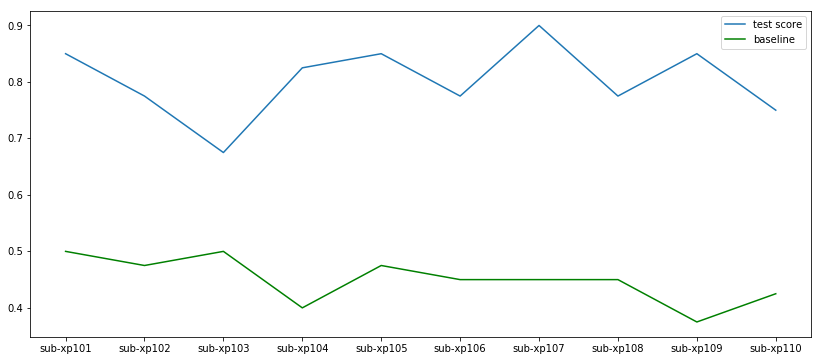

In [89]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(svm_results[['test score']], label = 'test score')
plt.plot(svm_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the SVM model using, as predictors, the fMRI data after a voxel size rescaling by a factor 2, performs better than the baseline for our group of subjects. 

In [90]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_fMRI_predictors_all_subjects_r2.npz', 
         svm_results = svm_results)

### **3.3 Voxel size rescaling by a factor 3**

In this section, we try to predict the brain state for **all subjects**, using the **fMRI data with a voxel size rescaling by a factor 3** and a **SVM model**. 

In [91]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 3. 
predictors_fMRI_r3_flatten, non_nan_indexes_fMRI_r3 = flatten_preprocessed_fMRI_data(predictors_fMRI_r3)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [92]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-2, 2, num = 3)
c_values

array([1.e-02, 1.e+00, 1.e+02])

In [93]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [94]:
# Run the model. 
svm_results = run_classification(grid_cv_svm, 'svm__C', predictors_fMRI_r3_flatten, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [95]:
# Display the results. 
svm_results

,svm__C,test score,baseline
sub-xp101,0.01,0.925,0.400
sub-xp102,0.01,0.700,0.475
sub-xp103,0.01,0.850,0.450
sub-xp104,0.01,0.850,0.450
sub-xp105,0.01,0.875,0.475
sub-xp106,0.01,0.825,0.450
sub-xp107,0.01,0.900,0.450
sub-xp108,0.01,0.775,0.450
sub-xp109,0.01,0.675,0.425
sub-xp110,0.01,0.825,0.325


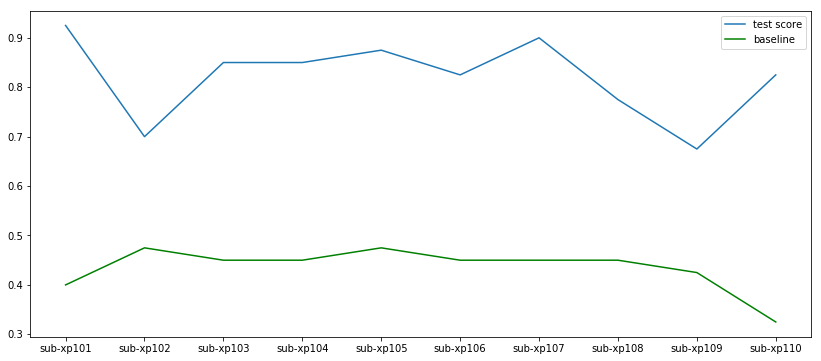

In [96]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(svm_results[['test score']], label = 'test score')
plt.plot(svm_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the SVM model using, as predictors, the fMRI data after a voxel size rescaling by a factor 3, performs better than the baseline for our group of subjects. 

In [97]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_fMRI_predictors_all_subjects_r3.npz', 
         svm_results = svm_results)

### **3.4 PCA with 200 components**

In this section, we try to predict the brain state for **all subjects**, using the **fMRI data transformed through a PCA of 200 components** and a **SVM model**. 

In [98]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-2, 2, num = 3)
c_values

array([1.e-02, 1.e+00, 1.e+02])

In [99]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [100]:
# Run the model. 
svm_results = run_classification(grid_cv_svm, 'svm__C', predictors_fMRI_PCA_200_components, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [101]:
# Display the results. 
svm_results

,svm__C,test score,baseline
sub-xp101,0.01,0.475,0.500
sub-xp102,0.01,0.450,0.425
sub-xp103,0.01,0.450,0.375
sub-xp104,0.01,0.450,0.375
sub-xp105,0.01,0.575,0.375
sub-xp106,0.01,0.650,0.500
sub-xp107,0.01,0.400,0.450
sub-xp108,0.01,0.525,0.475
sub-xp109,0.01,0.650,0.500
sub-xp110,0.01,0.400,0.500


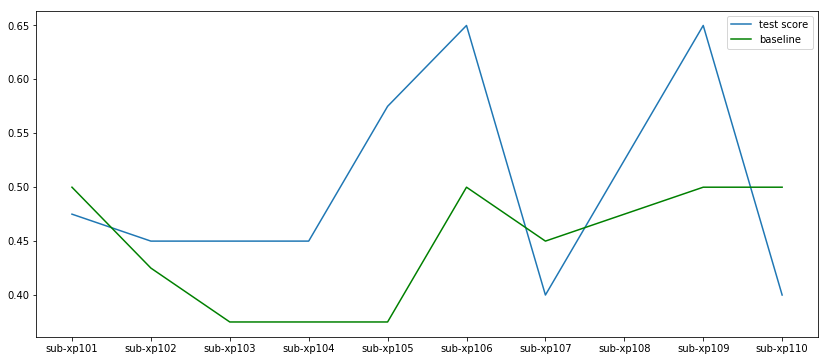

In [102]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(svm_results[['test score']], label = 'test score')
plt.plot(svm_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the SVM model using, as predictors, the fMRI data transformed through a PCA of 200 components, does not seem to perform much better than the baseline for our group of subjects. 

In [103]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_fMRI_predictors_all_subjects_PCA_200.npz', 
         svm_results = svm_results)

### **3.5 PCA with 10 components**

In this section, we try to predict the brain state for **all subjects**, using the **fMRI data transformed through a PCA of 10 components** and a **SVM model**. 

In [104]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-2, 2, num = 3)
c_values

array([1.e-02, 1.e+00, 1.e+02])

In [105]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [106]:
# Run the model. 
svm_results = run_classification(grid_cv_svm, 'svm__C', predictors_fMRI_PCA_10_components, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [107]:
# Display the results. 
svm_results

,svm__C,test score,baseline
sub-xp101,0.01,0.750,0.425
sub-xp102,1.00,0.700,0.500
sub-xp103,0.01,0.550,0.400
sub-xp104,100.00,0.725,0.450
sub-xp105,0.01,0.825,0.450
sub-xp106,1.00,0.600,0.400
sub-xp107,100.00,0.875,0.350
sub-xp108,1.00,0.775,0.450
sub-xp109,100.00,0.750,0.450
sub-xp110,1.00,0.550,0.375


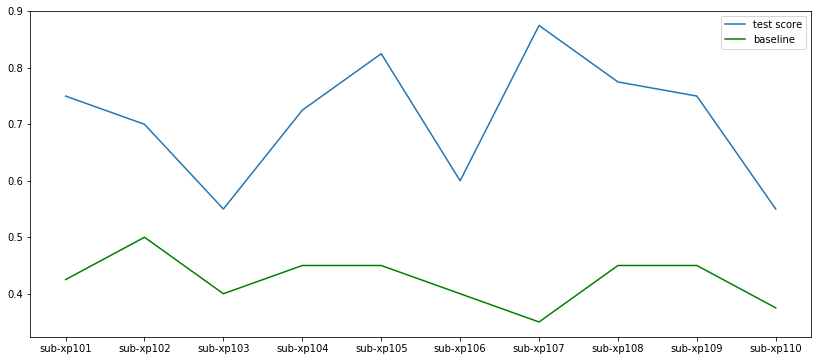

In [108]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(svm_results[['test score']], label = 'test score')
plt.plot(svm_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the SVM model using, as predictors, the fMRI data transformed through a PCA of 10 components, performs better than the baseline for our group of subjects. This seems counter-intuitive, since the PCA of 200 components gave poor results. In fact, it is very possible that the separating hyperplane of the SVM works better with a few relevant dimensions, while its performance degrades when we add other, less informative dimensions. We explore this question more in depth in the next section. 

In [109]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_fMRI_predictors_all_subjects_PCA_10.npz', 
         svm_results = svm_results)

### **3.6 PCA with a variable number of components**

In this section, we try to predict the brain state for **all subjects**, using the **fMRI data transformed through a PCA with a variable number of components** and a **SVM model**. 

In [110]:
# Define a function to run a classification model on PCA data. 
def run_classification_PCA(grid_cv, param_name, predictors_dict, target, nb_components):
    
    # Create a Pandas DataFrame to store the results. 
    model_results = pd.DataFrame()

    # Iterate through all subjects. 
    for subject_index in subjects:

        # Retrieve the predictors. 
        X = predictors_dict[subject_index][:, :nb_components]
        y = target

        # Divide the data into a train set and a test set. 
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

        # Create a baseline containing only the most frequent value in the train set. 
        most_frequent_value = np.bincount(y_tr.astype(int)).argmax()
        classification_baseline = np.sum(y_te.astype(int) == most_frequent_value) / y_te.shape[0]

        # Fit the model. 
        grid_cv.fit(X_tr, y_tr)

        # Compute the test score. 
        test_score = grid_cv.score(X_te, y_te)

        # Store the results in the DataFrame. 
        model_results.loc[subject_index, param_name] = grid_cv.best_params_[param_name]
        model_results.loc[subject_index, 'test score'] = test_score
        model_results.loc[subject_index, 'baseline'] = classification_baseline
        
    return model_results

In [111]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-2, 2, num = 3)
c_values

array([1.e-02, 1.e+00, 1.e+02])

In [112]:
# Create a NumPy array to store the results. 
mean_test_score_by_nb_components = np.zeros(200)
mean_baseline_by_nb_components = np.zeros(200)

# Iterate through the number of components. 
for nb_components in range(1, 201):
    
    # Create pipeline. 
    pipe_svm = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC())
    ])

    # Create cross-validation object. 
    grid_svm = {
        'svm__kernel': ['linear'],
        'svm__C': c_values,
        'svm__gamma': ['auto']
    }
    grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)
    
    # Run the model. 
    svm_results = run_classification_PCA(grid_cv_svm, 'svm__C', predictors_fMRI_PCA_200_components, y, nb_components)
    
    # Store the results in the NumPy array. 
    mean_test_score_by_nb_components[nb_components - 1] = svm_results['test score'].mean()
    mean_baseline_by_nb_components[nb_components - 1] = svm_results['baseline'].mean()

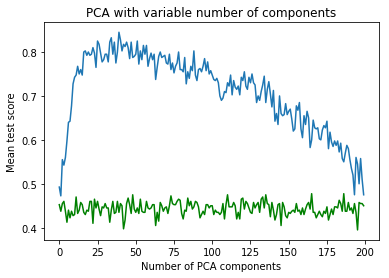

In [113]:
# Plot the results. 
plt.plot(mean_test_score_by_nb_components)
plt.plot(mean_baseline_by_nb_components, color = 'green')
plt.xlabel('Number of PCA components')
plt.ylabel('Mean test score')
plt.title('PCA with variable number of components');

**Result:** At first, the mean test score rises as the number of PCA components increases. Then, there is a slow decrease, until the mean test score falls near the baseline level.  

In [114]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_fMRI_predictors_all_subjects_PCA_variable.npz', 
         mean_test_score_by_nb_components = mean_test_score_by_nb_components,
         mean_baseline_by_nb_components = mean_baseline_by_nb_components)

## **4. Classification based on EEG and fMRI data**

Finally, we try to predict the brain state for **all subjects**, combining the **EEG bandpowers** and the **fMRI data transformed through a PCA of 10 components**. 

In [115]:
# Create a dictionary to hold the predictors. 
predictors_EEG_fMRI = dict()

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Concatenate the EEG and fMRI data, and store the results in the dictionary. 
    eeg_fmri_data = np.concatenate((predictors_fMRI_PCA_10_components[subject_index], predictors_EEG_200_samples[subject_index]), axis = 1)
    predictors_EEG_fMRI[subject_index] = eeg_fmri_data

### **4.1 K-Nearest Neighbors (k-NN)**

In the following cells, we **fine-tune, fit and compute predictions from a k-NN model**. 

In [116]:
# Define the set of values to explore, where k is the number of neighbors. 
k_values = np.arange(1, 50, 1)
k_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [117]:
# Create pipeline. 
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Create cross-validation object. 
grid_knn = {
    'knn__n_neighbors': k_values
}
grid_cv_knn = GridSearchCV(pipe_knn, grid_knn, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [118]:
# Run the model. 
knn_results = run_classification(grid_cv_knn, 'knn__n_neighbors', predictors_EEG_fMRI, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [119]:
# Display the results. 
knn_results

,knn__n_neighbors,test score,baseline
sub-xp101,3.0,0.825,0.425
sub-xp102,7.0,0.650,0.450
sub-xp103,5.0,0.750,0.425
sub-xp104,16.0,0.725,0.450
sub-xp105,3.0,0.825,0.425
sub-xp106,10.0,0.625,0.475
sub-xp107,4.0,0.875,0.475
sub-xp108,14.0,0.775,0.475
sub-xp109,6.0,0.600,0.475
sub-xp110,12.0,0.675,0.500


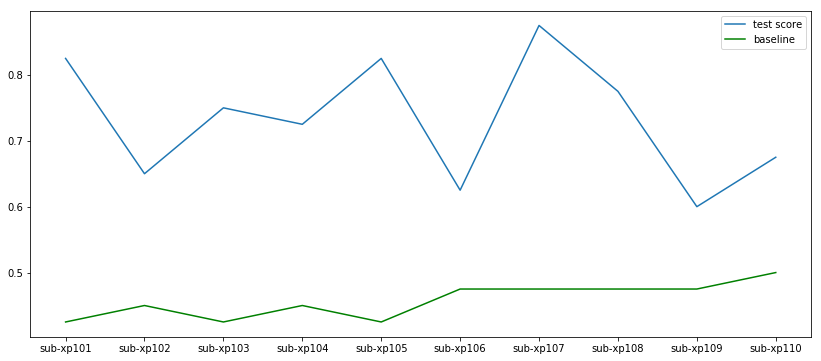

In [120]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(knn_results[['test score']], label = 'test score')
plt.plot(knn_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the k-NN model using the combined EEG-fMRI data as predictors performs better than the baseline for our group of subjects. 

### **4.2 Decision tree**

In the following cells, we **fine-tune, fit and compute predictions from a decision tree model**. 

In [121]:
# Define the set of values to explore, where d is the depth of the tree. 
d_values = np.arange(1, 50, 1)
d_values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [122]:
# Create pipeline. 
pipe_dt = Pipeline([
    ('scaler', None),
    ('dt', DecisionTreeClassifier(criterion = 'gini'))
])

# Create cross-validation object. 
grid_dt = {
    'dt__max_depth': d_values
}
grid_cv_dt = GridSearchCV(pipe_dt, grid_dt, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [123]:
# Run the model. 
dt_results = run_classification(grid_cv_dt, 'dt__max_depth', predictors_EEG_fMRI, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [124]:
# Display the results. 
dt_results

,dt__max_depth,test score,baseline
sub-xp101,4.0,0.700,0.475
sub-xp102,7.0,0.575,0.325
sub-xp103,32.0,0.775,0.400
sub-xp104,14.0,0.575,0.425
sub-xp105,14.0,0.775,0.400
sub-xp106,22.0,0.750,0.475
sub-xp107,13.0,0.825,0.500
sub-xp108,4.0,0.650,0.425
sub-xp109,28.0,0.725,0.475
sub-xp110,2.0,0.575,0.450


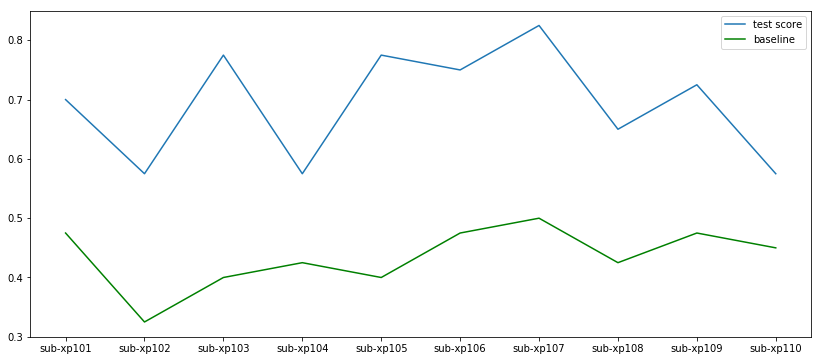

In [125]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(dt_results[['test score']], label = 'test score')
plt.plot(dt_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the decision tree model using the combined EEG-fMRI data as predictors performs better than the baseline for our group of subjects. 

### **4.3 Random forest**

In the following cells, we **fine-tune, fit and compute predictions from a random forest model**. 

In [126]:
# Define the set of values to explore, where n is the number of trees. 
n_values = np.arange(5, 105, 5)
n_values

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])

In [127]:
# Create pipeline. 
pipe_rf = Pipeline([
    ('scaler', None),
    ('rf', RandomForestClassifier(max_depth = None))
])

# Create cross-validation object. 
grid_rf = {
    'rf__n_estimators': n_values
}
grid_cv_rf = GridSearchCV(pipe_rf, grid_rf, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [128]:
# Run the model. 
rf_results = run_classification(grid_cv_rf, 'rf__n_estimators', predictors_EEG_fMRI, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [129]:
# Display the results. 
rf_results

,rf__n_estimators,test score,baseline
sub-xp101,50.0,0.800,0.475
sub-xp102,90.0,0.750,0.400
sub-xp103,75.0,0.800,0.300
sub-xp104,90.0,0.675,0.400
sub-xp105,55.0,0.800,0.475
sub-xp106,70.0,0.600,0.475
sub-xp107,30.0,0.900,0.400
sub-xp108,50.0,0.775,0.475
sub-xp109,90.0,0.600,0.425
sub-xp110,40.0,0.700,0.425


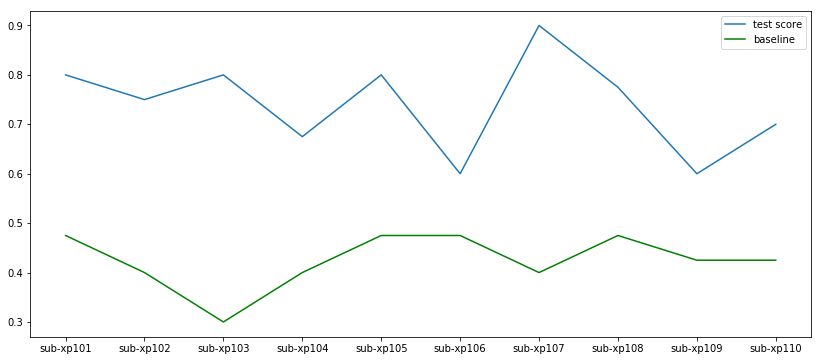

In [130]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(rf_results[['test score']], label = 'test score')
plt.plot(rf_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the random forest model using the combined EEG-fMRI data as predictors performs better than the baseline for our group of subjects. 

### **4.4 Support Vector Machine (SVM)**

In the following cells, we **fine-tune, fit and compute predictions from a SVM model**. 

In [131]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-3, 3, num = 10)
c_values

array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])

In [132]:
# Create pipeline. 
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Create cross-validation object. 
grid_svm = {
    'svm__kernel': ['linear'],
    'svm__C': c_values,
    'svm__gamma': ['auto']
}
grid_cv_svm = GridSearchCV(pipe_svm, grid_svm, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [133]:
# Run the model. 
svm_results = run_classification(grid_cv_svm, 'svm__C', predictors_EEG_fMRI, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [134]:
# Display the results. 
svm_results

,svm__C,test score,baseline
sub-xp101,0.021544,0.900,0.450
sub-xp102,0.100000,0.650,0.450
sub-xp103,0.464159,0.750,0.375
sub-xp104,0.021544,0.775,0.500
sub-xp105,0.100000,0.850,0.500
sub-xp106,0.100000,0.650,0.500
sub-xp107,2.154435,0.725,0.475
sub-xp108,0.021544,0.750,0.475
sub-xp109,2.154435,0.775,0.425
sub-xp110,0.464159,0.500,0.500


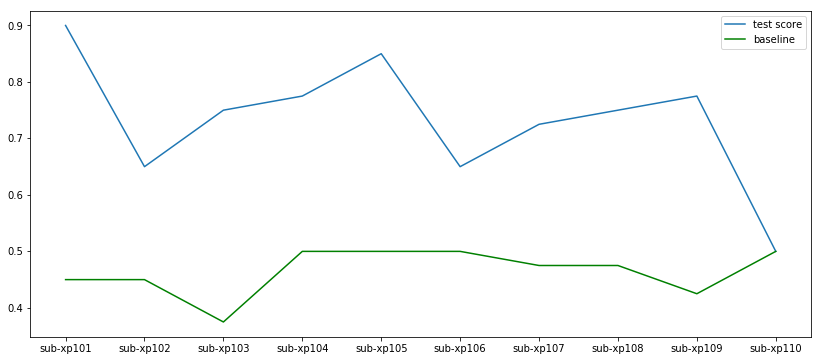

In [135]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(svm_results[['test score']], label = 'test score')
plt.plot(svm_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the SVM model using the combined EEG-fMRI data as predictors performs better than the baseline for our group of subjects. 

### **4.5 Logistic regression**

In the following cells, we **fine-tune, fit and compute predictions from a logistic regression model**. 

In [136]:
# Define the set of values to explore, where c is the C parameter. 
c_values = np.logspace(-7, 7, num = 10)
c_values

array([1.00000000e-07, 3.59381366e-06, 1.29154967e-04, 4.64158883e-03,
       1.66810054e-01, 5.99484250e+00, 2.15443469e+02, 7.74263683e+03,
       2.78255940e+05, 1.00000000e+07])

In [137]:
# Create pipeline. 
pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Create cross-validation object. 
grid_logreg = {
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['saga'],
    'logreg__C': c_values
}
grid_cv_logreg = GridSearchCV(pipe_logreg, grid_logreg, cv = 5, return_train_score = True, verbose = 0, n_jobs = -1)

In [138]:
# Run the model. 
logreg_results = run_classification(grid_cv_logreg, 'logreg__C', predictors_EEG_fMRI, y)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [139]:
# Display the results. 
logreg_results

,logreg__C,test score,baseline
sub-xp101,0.166810,0.775,0.425
sub-xp102,0.004642,0.750,0.500
sub-xp103,0.166810,0.650,0.450
sub-xp104,5.994843,0.625,0.475
sub-xp105,5.994843,0.700,0.500
sub-xp106,0.004642,0.725,0.475
sub-xp107,0.166810,0.800,0.425
sub-xp108,0.004642,0.725,0.475
sub-xp109,0.004642,0.700,0.475
sub-xp110,0.004642,0.550,0.450


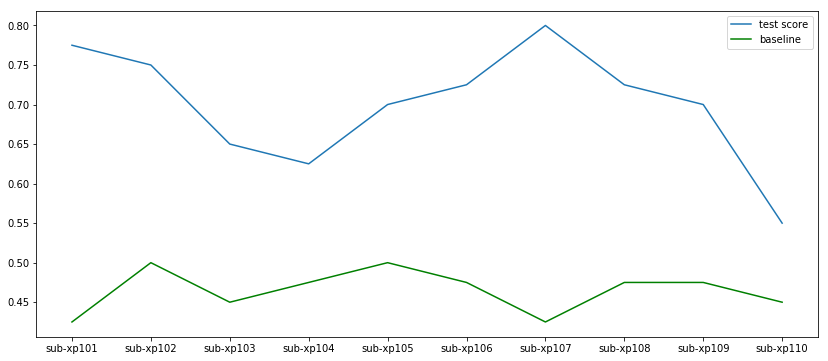

In [140]:
# Plot the results. 
plt.figure(figsize = ((14, 6)))
plt.plot(logreg_results[['test score']], label = 'test score')
plt.plot(logreg_results[['baseline']], label = 'baseline', color = 'green')
plt.legend();

**Result:** Overall, the logistic regression model using the combined EEG-fMRI data as predictors performs better than the baseline for our group of subjects. Now, we will explore further the predictions of our model for one particular subject. 

In [141]:
# Define an example subject. 
subject_index = subjects[0]

# Get the C parameter for this subject. 
best_param_logreg = logreg_results.loc[subject_index, 'logreg__C']
best_param_logreg

# Retrieve the predictors for this subject. 
X = predictors_EEG_fMRI[subject_index]

# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

In [142]:
# Create pipeline. 
pipe_logreg_optimal = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class = 'multinomial', solver = 'saga', C = best_param_logreg))
])

# Fit optimal logistic regression. 
pipe_logreg_optimal.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=0.1668100537200059, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False))])

In [143]:
# Compute and display the predictions. 
y_pred_logreg = pipe_logreg_optimal.predict(X_te)
y_pred_logreg

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1])

In [144]:
# Compare the true and predicted target values. 
pred_comparison = pd.DataFrame([y_te, y_pred_logreg], index = ['y_te', 'y_pred_logreg']).T
pred_comparison.T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
y_te,0,1,0,0,0,0,0,1,1,0,...,1,0,1,1,1,1,1,1,0,1
y_pred_logreg,0,1,0,0,0,1,0,1,1,0,...,1,0,0,1,1,1,1,1,0,1


In [145]:
# Rename the labels. 
y_te = np.array(['rest', 'task'])[y_te]
y_pred_logreg = np.array(['rest', 'task'])[y_pred_logreg]

# Display a Scikit-learn confusion matrix. 
confusion_matrix_logreg = scikit_learn_confusion_matrix(y_te, y_pred_logreg)
confusion_matrix_logreg

Predictions,rest,task
True class,,
rest,13,6
task,3,18


In the following cells, we explore the results from the logistic regression by analyzing the **probabilities computed for each target value**. In particular, we look at the predicted probability for the true target value. 

In [146]:
# Get and display the encoding order. 
encoding_order = np.unique(y_te)
encoding_order

array(['rest', 'task'], dtype='<U4')

In [147]:
# Compute the probabilities and convert them into a DataFrame with the appropriate column order. 
logreg_probabilities = np.round(pipe_logreg_optimal.predict_proba(X_te), 4)
logreg_probabilities = pd.DataFrame(logreg_probabilities, columns = encoding_order)
logreg_probabilities = logreg_probabilities[['rest', 'task']]

# Add the predicted and true target values. 
logreg_probabilities['predicted target'] = y_pred_logreg
logreg_probabilities['true target'] = y_te

# Compute the predicted probability for the true target value. 
for index in range(0, logreg_probabilities.shape[0]):
    logreg_probabilities.loc[index, 'probability of true target value'] = logreg_probabilities.loc[index, y_te[index]]

# Display the DataFrame. 
logreg_probabilities

,rest,task,predicted target,true target,probability of true target value
0,0.8055,0.1945,rest,rest,0.8055
1,0.3690,0.6310,task,task,0.6310
2,0.9874,0.0126,rest,rest,0.9874
3,0.9785,0.0215,rest,rest,0.9785
4,0.8993,0.1007,rest,rest,0.8993
5,0.1826,0.8174,task,rest,0.1826
6,0.9880,0.0120,rest,rest,0.9880
7,0.0700,0.9300,task,task,0.9300
8,0.1003,0.8997,task,task,0.8997
9,0.9970,0.0030,rest,rest,0.9970


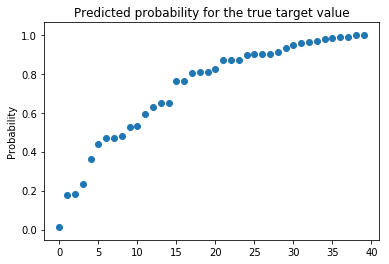

In [148]:
# Display the predicted probability for the true target value, sorted in ascending order. 
plt.scatter(range(0, logreg_probabilities.shape[0]), logreg_probabilities['probability of true target value'].sort_values());
plt.ylabel('Probability')
plt.title('Predicted probability for the true target value');

As we can see, the probability distribution is different when we use the combined EEG-fMRI data as predictors, in comparison with the EEG bandpowers alone. For a large proportion of data points, we have now a **high predicted probability** for the true target value. 

In [149]:
# Save the results into a .npz file. 
np.savez(results_path + 'classification_with_combined_EEG_fMRI_predictors_all_subjects.npz', 
         knn_results = knn_results, 
         dt_results = dt_results, 
         rf_results = rf_results, 
         svm_results = svm_results, 
         logreg_results = logreg_results, 
         logreg_probabilities = logreg_probabilities)